In [1]:
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
print(tf.keras.__version__)

2.2.0
2.3.0-tf


# 一 构建简单网络

## 1 创建网络
使用 tf.keras.utils.plot_model() 需要使用pip安装好pydot以及brew安装好graphviz

In [2]:
inputs = tf.keras.Input(shape=(784,), name='img')
h1 = layers.Dense(32, activation='relu')(inputs)
h2 = layers.Dense(32, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_model') # name字符串中不能包含空格

In [3]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


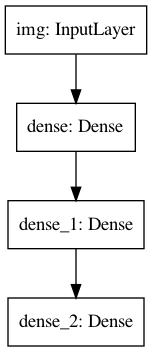

In [4]:
tf.keras.utils.plot_model(model, to_file='mnist_model.png')

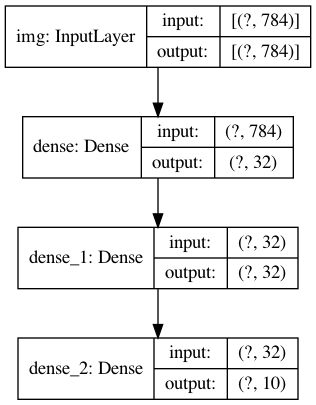

In [5]:
tf.keras.utils.plot_model(model, to_file='model_info.png', show_shapes=True)

## 2 训练、验证及测试

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
             loss='sparse_categorical_crossentropy', # 直接填api，后面会报错
             metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('test loss: ', test_scores[0])
print('test acc: ', test_scores[1])

Epoch 1/5
750/750 [==============================] - 1s 2ms/step - loss: 0.4221 - accuracy: 0.8811 - val_loss: 0.2256 - val_accuracy: 0.9341
Epoch 2/5
750/750 [==============================] - 1s 1ms/step - loss: 0.2050 - accuracy: 0.9404 - val_loss: 0.1762 - val_accuracy: 0.9499
Epoch 3/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1649 - accuracy: 0.9513 - val_loss: 0.1644 - val_accuracy: 0.9533
Epoch 4/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1397 - accuracy: 0.9583 - val_loss: 0.1434 - val_accuracy: 0.9586
Epoch 5/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1240 - accuracy: 0.9638 - val_loss: 0.1387 - val_accuracy: 0.9607
test loss:  0.1350218802690506
test acc:  0.961899995803833


## 3 模型保持和序列化

In [7]:
model.save('model_save.h5')
del model
model = tf.keras.models.load_model('model_save.h5')

# 二 使用共享网络创建多个模型
在函数API中，通过在图层图中指定其输入和输出来创建模型。 这意味着可以使用单个图层图来生成多个模型。

In [8]:
encode_input = tf.keras.Input(shape=(28,28,1), name='img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = tf.keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

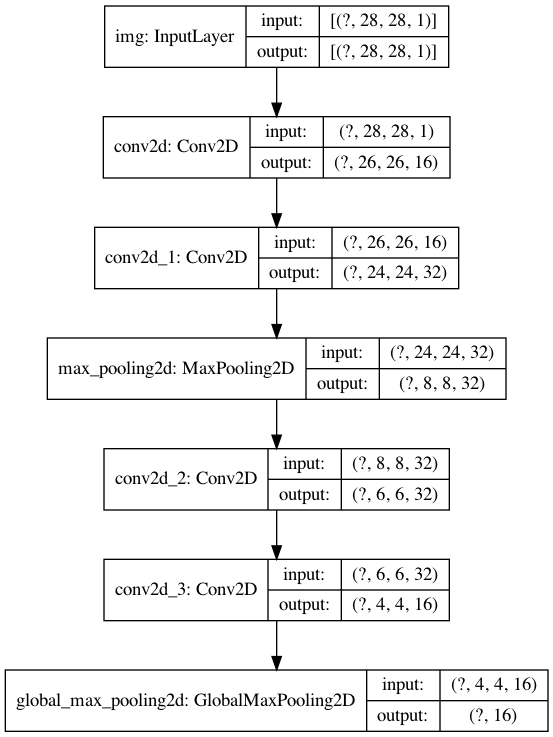

In [9]:
tf.keras.utils.plot_model(encode_model, to_file='encode_model.png', show_shapes=True)

In [10]:
h2 = layers.Reshape((4, 4, 1))(encode_output)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)

autoencoder = tf.keras.Model(inputs=encode_input, outputs=decode_output, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                

可以把整个模型，当作一层网络使用

In [11]:
encode_input = tf.keras.Input(shape=(28,28,1), name='src_img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = tf.keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
src_img (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

In [12]:
decode_input = tf.keras.Input(shape=(16,), name='encoded_img')
h2 = layers.Reshape((4, 4, 1))(decode_input)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)
decode_model = tf.keras.Model(inputs=decode_input, outputs=decode_output, name='decoder')
decode_model.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_img (InputLayer)     [(None, 16)]              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 6, 6, 16)          160       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 26, 26, 16)        4624      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 1)         145 

In [13]:
autoencoder_input = tf.keras.Input(shape=(28,28,1), name='img')
h3 = encode_model(autoencoder_input)
autoencoder_output = decode_model(h3)
autoencoder = tf.keras.Model(inputs=autoencoder_input, outputs=autoencoder_output,
                          name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                18672     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


# 三 复杂网络结构构建

## 1 多输入与多输出网络

In [14]:
# 构建一个根据文档内容、标签和标题，预测文档优先级和执行部门的网络
# 超参
num_words = 2000
num_tags = 12
num_departments = 4

# 输入
body_input = tf.keras.Input(shape=(None,), name='body')
title_input = tf.keras.Input(shape=(None,), name='title')
tag_input = tf.keras.Input(shape=(num_tags,), name='tag')

# 嵌入层
body_feat = layers.Embedding(num_words, 64)(body_input)
title_feat = layers.Embedding(num_words, 64)(title_input)

# 特征提取层
body_feat = layers.LSTM(32)(body_feat)
title_feat = layers.LSTM(128)(title_feat)
features = layers.concatenate([title_feat,body_feat, tag_input])

# 分类层
priority_pred = layers.Dense(1, activation='sigmoid', name='priority')(features)
department_pred = layers.Dense(num_departments, activation='softmax', name='department')(features)

# 构建模型
model = tf.keras.Model(inputs=[body_input, title_input, tag_input],
                    outputs=[priority_pred, department_pred])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     128000      title[0][0]                      
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     128000      body[0][0]                       
______________________________________________________________________________________________

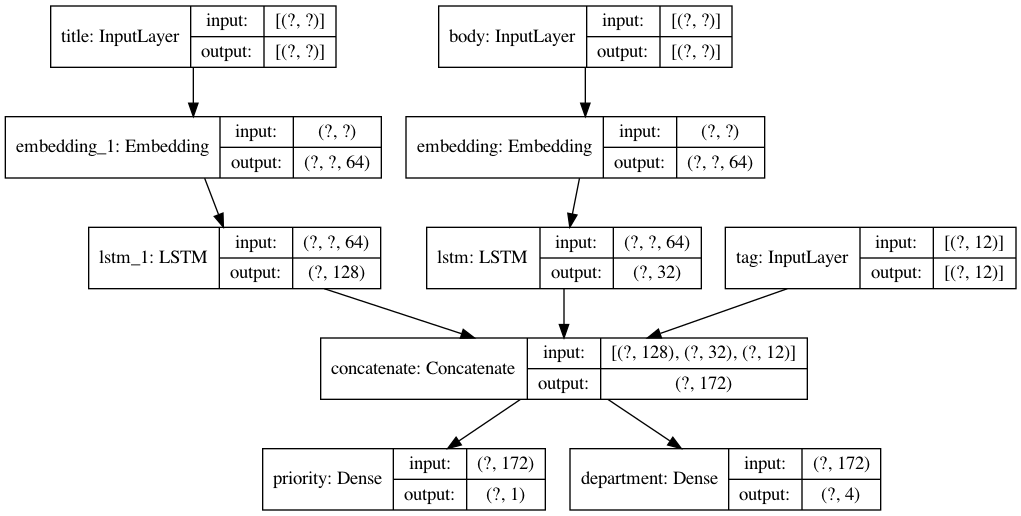

In [15]:
tf.keras.utils.plot_model(model, 'multi_model.png', show_shapes=True)

In [16]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3),
             loss={'priority': 'binary_crossentropy',
                  'department': 'categorical_crossentropy'},
             loss_weights=[1., 0.2])

In [17]:
import numpy as np
# 载入输入数据
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tag_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')
# 标签
priority_label = np.random.random(size=(1280, 1))
department_label = np.random.randint(2, size=(1280, num_departments))
# 训练
history = model.fit(
    {'title': title_data, 'body':body_data, 'tag':tag_data},
    {'priority':priority_label, 'department':department_label},
    batch_size=32,
    epochs=5
)

Epoch 1/5
40/40 [==============================] - 1s 30ms/step - loss: 1.3977 - priority_loss: 0.6990 - department_loss: 3.4933
Epoch 2/5
40/40 [==============================] - 1s 32ms/step - loss: 1.4084 - priority_loss: 0.6996 - department_loss: 3.5442
Epoch 3/5
40/40 [==============================] - 1s 35ms/step - loss: 1.3629 - priority_loss: 0.6986 - department_loss: 3.3212
Epoch 4/5
40/40 [==============================] - 1s 35ms/step - loss: 1.3360 - priority_loss: 0.6976 - department_loss: 3.1923
Epoch 5/5
40/40 [==============================] - 1s 35ms/step - loss: 1.3065 - priority_loss: 0.6969 - department_loss: 3.0482


## 2 小型残差网络

In [18]:
inputs = tf.keras.Input(shape=(32,32,3), name='img')
h1 = layers.Conv2D(32, 3, activation='relu')(inputs)
h1 = layers.Conv2D(64, 3, activation='relu')(h1)
block1_out = layers.MaxPooling2D(3)(h1)

h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(block1_out)
h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(h2)
block2_out = layers.add([h2, block1_out])

h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(block2_out)
h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(h3)
block3_out = layers.add([h3, block2_out])

h4 = layers.Conv2D(64, 3, activation='relu')(block3_out)
h4 = layers.GlobalMaxPool2D()(h4)
h4 = layers.Dense(256, activation='relu')(h4)
h4 = layers.Dropout(0.5)(h4)
outputs = layers.Dense(10, activation='softmax')(h4)

model = tf.keras.Model(inputs, outputs, name='small_resnet')

In [19]:
model.summary()

Model: "small_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_9[0][0]                   
_______________________________________________________________________________________

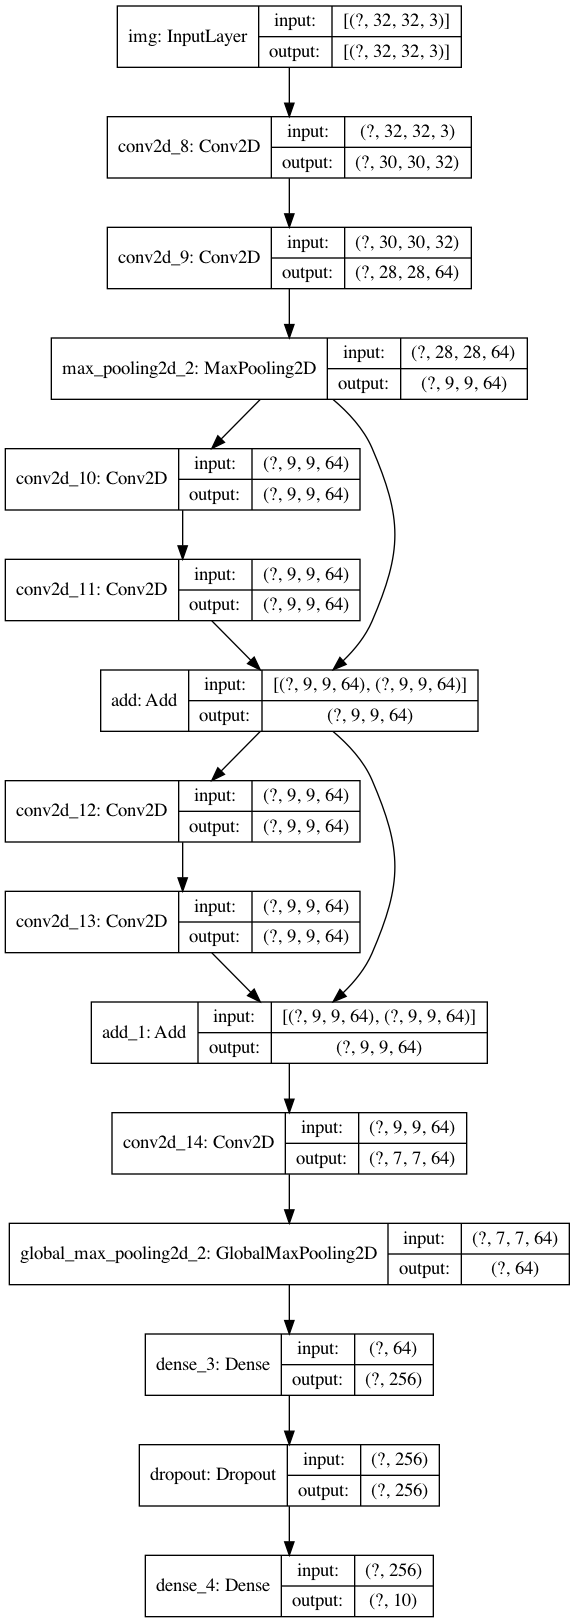

In [20]:
tf.keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)

In [21]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3),
             loss='categorical_crossentropy',
             metrics=['acc'])
model.fit(x_train, y_train,
         batch_size=64,
         epochs=1,
         validation_split=0.2)

625/625 [==============================] - 77s 123ms/step - loss: 1.8757 - acc: 0.2885 - val_loss: 1.5739 - val_acc: 0.4005


In [22]:
model.predict(x_test, batch_size=32)

array([[8.3366241e-03, 1.6032114e-03, 1.4169887e-01, ..., 6.8623342e-02,
        3.8199436e-03, 4.0120971e-03],
       [2.8194261e-01, 9.3434632e-02, 3.4937283e-03, ..., 7.4221013e-04,
        5.3736722e-01, 7.9380162e-02],
       [1.7071532e-01, 8.8161029e-02, 5.0437633e-02, ..., 3.8390454e-02,
        3.8401586e-01, 1.3904475e-01],
       ...,
       [2.3574941e-03, 1.3815128e-04, 5.3429648e-02, ..., 3.7798554e-01,
        3.3523305e-04, 6.0489558e-04],
       [3.8111422e-02, 2.5039177e-02, 1.2828457e-01, ..., 2.8315133e-01,
        2.2411201e-02, 2.2412244e-02],
       [3.3072799e-03, 6.0717715e-04, 4.9486827e-02, ..., 6.9092000e-01,
        1.2112402e-03, 1.4433370e-03]], dtype=float32)

# 四 共享网络层

In [23]:
share_embedding = layers.Embedding(1000, 64)

input1 = tf.keras.Input(shape=(None,), dtype='int32')
input2 = tf.keras.Input(shape=(None,), dtype='int32')

feat1 = share_embedding(input1)
feat2 = share_embedding(input2)

# 五 模型复用

In [24]:
from tensorflow.keras.applications import resnet
vgg19 = tf.keras.applications.VGG19()

In [25]:
feature_list = [layer.output for layer in vgg19.layers]

In [26]:
feature_list

[<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Identity:0' shape=(None, 224, 224, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Identity:0' shape=(None, 224, 224, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/Identity:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Identity:0' shape=(None, 112, 112, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Identity:0' shape=(None, 112, 112, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/Identity:0' shape=(None, 56, 56, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Identity:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Identity:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Identity:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'block3_conv4/Identity:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/Identity:0' shape=(None, 28, 28, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Identity:0' shape=(None,

In [27]:
feat_ext_model = tf.keras.Model(inputs=vgg19.input, outputs=feature_list)

In [28]:
feat_ext_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

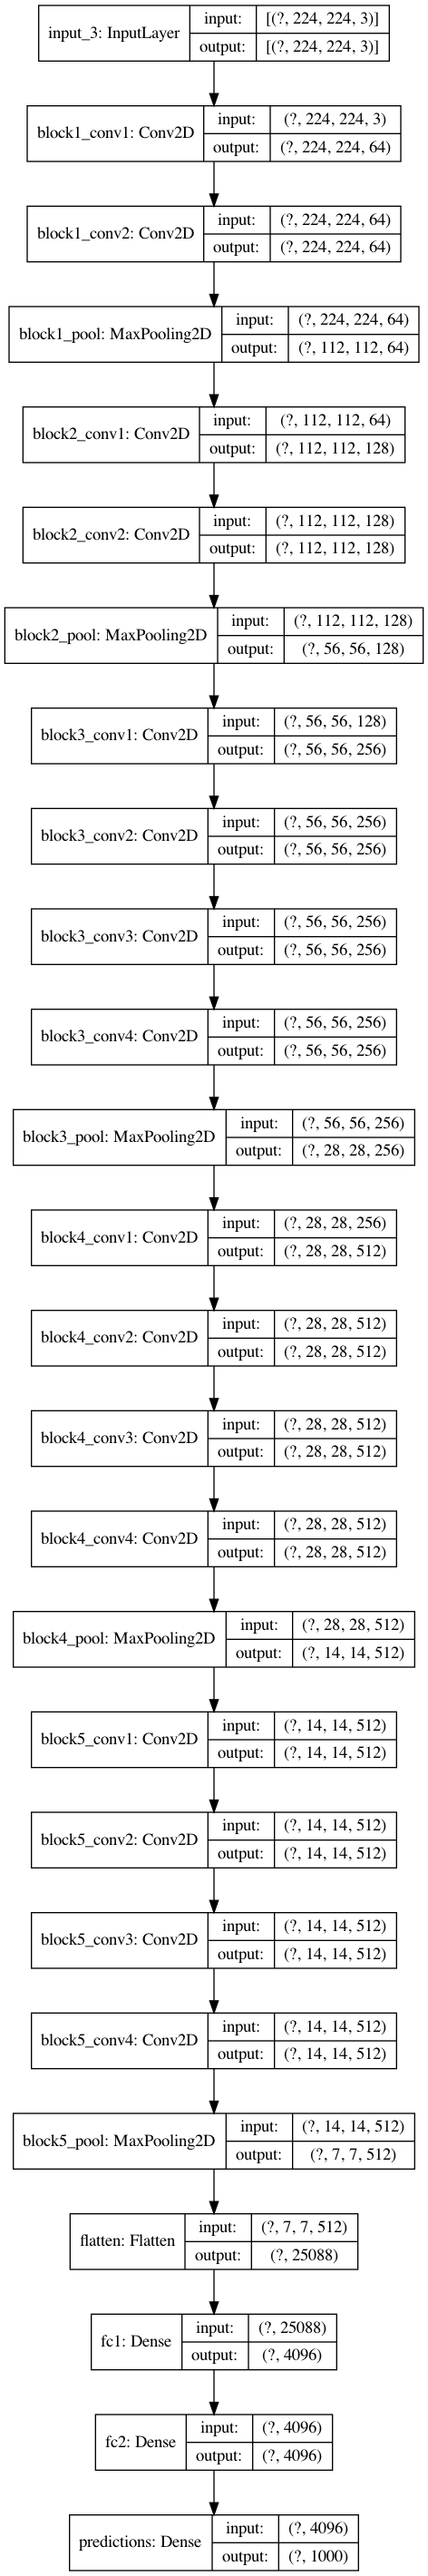

In [29]:
tf.keras.utils.plot_model(feat_ext_model, 'feat_ext_model.png', show_shapes=True)

In [30]:
img = np.random.random((1, 224, 224, 3)).astype('float32')
ext_features = feat_ext_model(img)

# 六 自定义网络层

In [32]:
# import tensorflow as tf
# import tensorflow.keras as keras
class MyDense(layers.Layer):
    def __init__(self, units=32):
        super(MyDense, self).__init__()
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {'units': self.units}

inputs = tf.keras.Input((4,))
outputs = MyDense(10)(inputs)
model = tf.keras.Model(inputs, outputs)
config = model.get_config()
new_model = tf.keras.Model.from_config(
config, custom_objects={'MyDense':MyDense}
)

In [33]:
# 在自定义网络层调用其他网络层

# 超参
time_step = 10
batch_size = 32
hidden_dim = 32
inputs_dim = 5

# 网络
class MyRnn(layers.Layer):
    def __init__(self):
        super(MyRnn, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection1 = layers.Dense(units=hidden_dim, activation='relu')
        self.projection2 = layers.Dense(units=hidden_dim, activation='relu')
        self.classifier = layers.Dense(1, activation='sigmoid')
    def call(self, inputs):
        outs = []
        states = tf.zeros(shape=[inputs.shape[0], self.hidden_dim])
        for t in range(inputs.shape[1]):
            x = inputs[:,t,:]
            h = self.projection1(x)
            y = h + self.projection2(states)
            states = y
            outs.append(y)
        # print(outs)
        features = tf.stack(outs, axis=1)
        print(features.shape)
        return self.classifier(features)

# 构建网络
inputs = tf.keras.Input(batch_shape=(batch_size, time_step, inputs_dim))
x = layers.Conv1D(32, 3)(inputs)
print(x.shape)
outputs = MyRnn()(x)
model = tf.keras.Model(inputs, outputs)


rnn_model = MyRnn()
_ = rnn_model(tf.zeros((1, 10, 5)))

(32, 8, 32)
(32, 8, 32)
(1, 10, 32)
